# Introduction

In this project, the airbnb data of Seattle area and Boston area were analyzed. This analysis focuses on three sections. In section 1, I will exam the types of amenities that appear the most in bosth Seattle airbnb host and Boston Airbnb host and exam whether there is a regional difference. 2.I am interested in finding out how the objective features of the host that affect the price. These features including location, number of bedroom, number of bathroom, bed type ,property type, amenitites and cancellation policy. 3. Since the data contains customer reiews. I am interesting the most frequency words that appear in reviews for high rating host and low rating host.


# load package and raw data

In [1]:
#import package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import sklearn

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
#import nltk
#nltk.download('stopwords')
englishwords=set(nltk.corpus.words.words())
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import metrics
%matplotlib inline

In [2]:
#load package
seattle_reviews=pd.read_csv("seattle/reviews.csv")
boston_reviews=pd.read_csv("boston/reviews.csv")

In [3]:
seattle_reviews.head()

listing_id        id        date  reviewer_id reviewer_name  \
0     7202016  38917982  2015-07-19     28943674        Bianca   
1     7202016  39087409  2015-07-20     32440555         Frank   
2     7202016  39820030  2015-07-26     37722850           Ian   
3     7202016  40813543  2015-08-02     33671805        George   
4     7202016  41986501  2015-08-10     34959538          Ming   

                                            comments  
0  Cute and cozy place. Perfect location to every...  
1  Kelly has a great room in a very central locat...  
2  Very spacious apartment, and in a great neighb...  
3  Close to Seattle Center and all it has to offe...  
4  Kelly was a great host and very accommodating ...

In [4]:
boston_reviews.head()

listing_id       id        date  reviewer_id reviewer_name  \
0     1178162  4724140  2013-05-21      4298113       Olivier   
1     1178162  4869189  2013-05-29      6452964     Charlotte   
2     1178162  5003196  2013-06-06      6449554     Sebastian   
3     1178162  5150351  2013-06-15      2215611        Marine   
4     1178162  5171140  2013-06-16      6848427        Andrew   

                                            comments  
0  My stay at islam's place was really cool! Good...  
1  Great location for both airport and city - gre...  
2  We really enjoyed our stay at Islams house. Fr...  
3  The room was nice and clean and so were the co...  
4  Great location. Just 5 mins walk from the Airp...

In [3]:
seattle_listings=pd.read_csv("seattle/listings.csv")
boston_listings=pd.read_csv("boston/listings.csv")

# Section 3. Analyzing review comments

(section 1 and section 2 are presented after this section)

In this section, I will process the user comments in the dataset. I would like to find out what kind of words that appear the most in the comments of a high rating hoster or low rating hoster. Specifically, I would like to see what kind of adjective/adverb words and verb words that appear the most.

## Data Preparation

The first thing I need to do is to combine the dataset that contains the comments  and the data set that contains the rating together.

In [10]:
seattle_reviews["rating score"]=np.nan
boston_reviews["rating score"]=np.nan

In [11]:
for i in seattle_reviews.index:
    print (i, end="\r")
    seattle_reviews["rating score"][i]=seattle_listings[seattle_listings["id"]==seattle_reviews["listing_id"][i]]["review_scores_rating"]

E:\Users\xbxb\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
for i in boston_reviews.index:
    print (i, end="\r")
    boston_reviews["rating score"][i]=boston_listings[boston_listings["id"]==boston_reviews["listing_id"][i]]["review_scores_rating"]

E:\Users\xbxb\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
seattle_reviews.to_csv('seattle_reviews.csv', sep=';', index = False)
boston_reviews.to_csv('boston_reviews.csv', sep=';', index = False)

The data contains missing comments, a mixture of different language. I want to remove the missing comments, keep only english comments. In addition, I would like to create two function to help me filter out non-adj and non adv words/non-verb words

## Feature engineering

### Clean up the data

In [175]:
def clean_comments(comments):
    """
    input: a string
    output: english_comments: a clean string without any punctuation,and non english words
            tags: a tags that marks the type of each words in the comments
    process: remove punctuation, remove nonenglish words,remove stopswords
    """
    tempcomments=word_tokenize(comments)
    english_comments=[x.lower() for x in tempcomments if x.lower() in englishwords and x not in STOPWORDS]
    #english_comments=[x.lower() for x in tempcomments if x.lower() in englishwords]
    tags=nltk.pos_tag(english_comments)
    
    return english_comments,tags
    

### Detect adj/adv words/ detect verb words

Since I am interested in the adj/adv and verb words that appears in the comments, I need to extract the words that I am interested in. In the previous cleam_comments function, all the words have been tokenlized. So I can use the tags to distinguish the type of different words

detail about the tags is lised in the project note

In [129]:
def keep_adj_adv_words(comments):
    """
    input: comments: a cleaned comments from clean_comments function. It should be a list of str
            tags: a list that contains the type of each words in comments
    output: a comment that only contains adj and adv words
    process: remove any non-adj and adv words
    """
    english_comments,tags=clean_comments(comments)
    for i in range(0,len( english_comments)):
        if tags[i][1] not in ["JJ","JJR","JJS","RB","RBR","RBS"]:
               english_comments.remove(tags[i][0])
    return english_comments

    

In [130]:
def keep_verb_words(comments):
    """
    input: comments: a cleaned comments from clean_comments function. It should be a list of str
            tags: a list that contains the type of each words in comments
    output: a comment that only verb root words
    process: remove any non-verb words and convert them to the root words
    """
    english_comments,tags=clean_comments(comments)
    for i in range(0,len(english_comments)):
        if tags[i][1] not in ["VB","VBD","VBG","VBN","VBP","VBZ"]:
               english_comments.remove(tags[i][0])
    for i in range(0,len(english_comments)):
        english_comments[i]=wordnet_lemmatizer.lemmatize(english_comments[i], 'v')
    
    return english_comments


### Pack everything together

Create a function to process the raw data

In [131]:
def data_process_filter(df,columns,mode):
    """
    input: df       dataframe
           columns  the column name that contains text string
           mode    1 for adj/adv filter, 2 for verb filter
    output: cleaned dataframe with cleaned text
            removed nan in columns with text string
            remove puntuation, non-english words and apply adj/adv filter or verb filter to the text string
    """
    #remove the row with missing comments
    newdf=df[df[columns].isnull()==False]
    if mode==1:
        newdf[columns]=newdf[columns].apply(keep_adj_adv_words)
    elif mode ==2:
        newdf[columns]=newdf[columns].apply(keep_verb_words)
    else:
        print("Incorrect mode number. 1 for adj/adv filter, 2 for verb filter")
        
    
    return newdf

In [176]:
seattle_reviews_adjv=data_process_filter(seattle_reviews,'comments',1)

E:\Users\xbxb\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [177]:
boston_reviews_adjv=data_process_filter(boston_reviews,'comments',1)

E:\Users\xbxb\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [178]:
seattle_reviews_verb=data_process_filter(seattle_reviews,'comments',2)

E:\Users\xbxb\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [179]:
boston_reviews_verb=data_process_filter(boston_reviews,'comments',2)

E:\Users\xbxb\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [180]:
seattle_reviews_adjv.to_csv('seattle_reviews_adjv.csv', sep=';', index = False)
seattle_reviews_verb.to_csv('seattle_reviews_verb.csv', sep=';', index = False)
boston_reviews_adjv.to_csv('boston_reviews_adjv.csv', sep=';', index = False)
boston_reviews_verb.to_csv('boston_reviews_verb.csv', sep=';', index = False)

### Combine data

In [181]:
all_reviews_adjv=pd.concat([seattle_reviews_adjv,boston_reviews_adjv],axis=0,ignore_index=True)

In [182]:
all_reviews_verb=pd.concat([seattle_reviews_verb,boston_reviews_verb],axis=0,ignore_index=True)

## Exploratory data analysis

### Define postive and negative review using rating score

now I would like to create a words cloud to visualize the most freqeuntly appeared words
First I will use 55 as a baseline

In [260]:
all_reviews_adjv_positive=all_reviews_adjv[all_reviews_adjv["rating score"]>55]
all_reviews_adjv_negative=all_reviews_adjv[all_reviews_adjv["rating score"]<=55]

### Countvectorizer

I would like to create a countvectorizer to help me count the most frequently appear words

In [261]:
def count_freq(data_col):
    """
    input: input data will be the column that contains the text
    output: words_freq_df will shows that words and their corresponding freqeuncy
    This function will first use countvectorizer() to create a matric, each word is represented in a column. 
    If one observation contains this word, the value will be one. The sum_words will count the freqency of the appearance
    of each words. the vectorizer conatins the mapping between word's text string and their index in data_vec. 
    """
    vectorizer=CountVectorizer()
    data_col=[" ".join(i) for i in data_col.values]
    data_vec=vectorizer.fit_transform(data_col)
    sum_words=data_vec.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vectorizer.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    words_freq_df=pd.DataFrame(data=words_freq,columns=["word","count"])
    return words_freq_df


In [262]:
top_postive_adjv=count_freq(all_reviews_adjv_positive["comments"]).iloc[0:50]

In [263]:
top_negative_adjv=count_freq(all_reviews_adjv_negative["comments"]).iloc[0:50]

### Words cloud for adj/adv

In [264]:
def create_wordcloud(data,stopwordslist,topnumber=100):
    wordcloud = WordCloud(
    width = 600,
    height = 400,
    background_color = 'white',
    max_words=topnumber,
    stopwords = stopwordslist).generate(str(data))
    fig = plt.figure(figsize = (10,8))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()
    
    

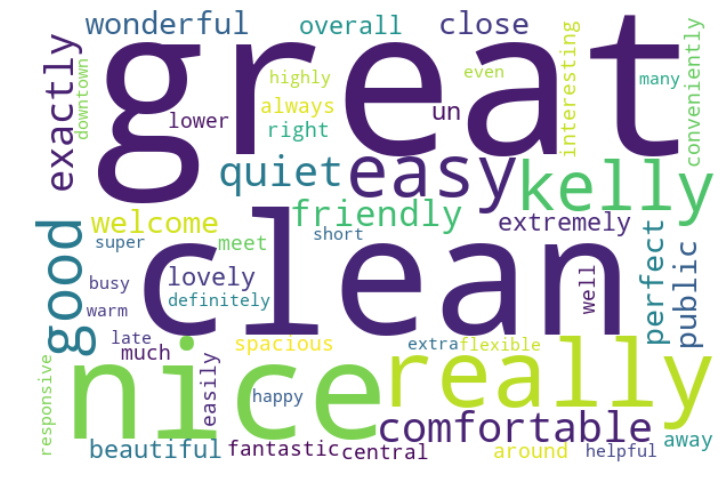

In [265]:
create_wordcloud(all_reviews_adjv_positive["comments"],STOPWORDS,50)

In [266]:
stopwords=set(STOPWORDS)

In [267]:
stopwords.update(top_postive_adjv["word"])

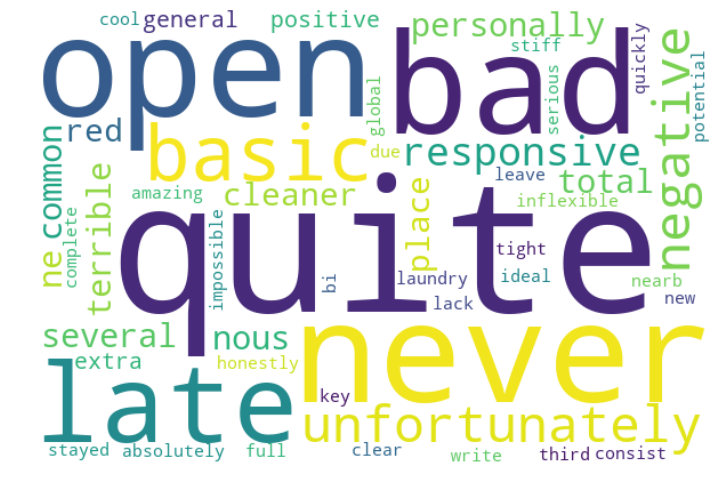

In [268]:
create_wordcloud(all_reviews_adjv_negative["comments"],stopwords,50)

### words cloud for verb

In [269]:
all_reviews_verb_positive=all_reviews_verb[all_reviews_verb["rating score"]>55]
all_reviews_verb_negative=all_reviews_verb[all_reviews_verb["rating score"]<=55]
top_positive_verb=count_freq(all_reviews_verb_positive["comments"]).iloc[0:50]
top_negative_verb=count_freq(all_reviews_verb_negative["comments"]).iloc[0:50]

In [270]:
stopwords_verb_pos=set(STOPWORDS)
stopwords_verb_pos.update(["go","walk","leave","make","take","stay","look"])

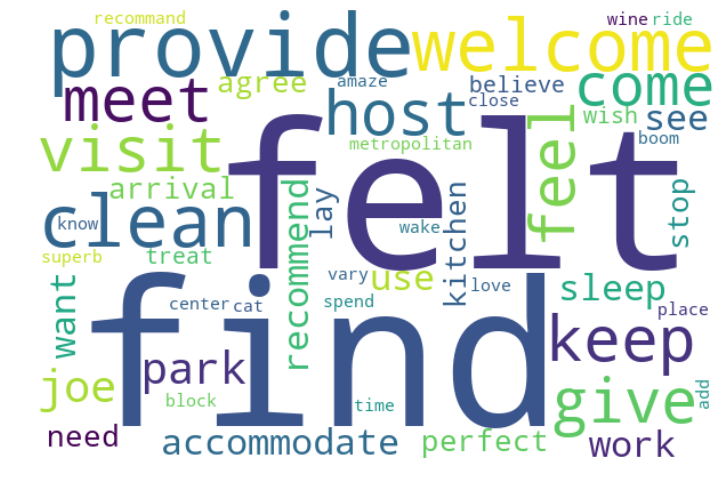

In [271]:
create_wordcloud(all_reviews_verb_positive["comments"],stopwords_verb_pos,50)

In [272]:
stopwords_verb_neg=stopwords_verb_pos
stopwords_verb_neg.update(top_positive_verb["word"])
stopwords_verb_neg.update(["accurate","arrival"])

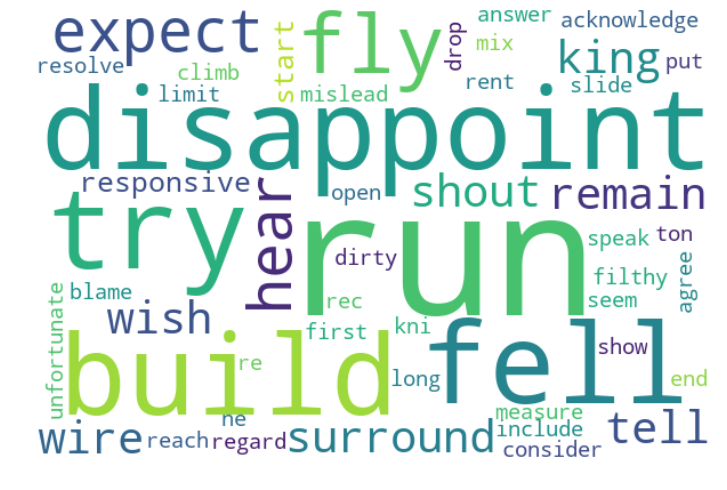

In [273]:
create_wordcloud(all_reviews_verb_negative["comments"],stopwords_verb_neg,50)

# Section 2. Most frequent amenities and less frequent amenities

In this section, I will check the "amenities" column in the dataset. Seattle is on the west side of US. Boston is on the east side. The culture and location difference may lead to a different lif style. This may be reflected by the amenities in airbnb.
I would like to see whether the amenities of airbnb in seattle area are different than the amenities of airbnb in boston area

## Feature Engineering

Since the text data in amenities columns is a mixture of different amenities characters and seperated by ",". I need to extract the amenities feature from each text string

In [4]:
def split_amenities(text):
    newtext=[x for x in text if x not in string.punctuation or x==","]
    newtext="".join(newtext)
    newtext=newtext.split(sep=",")
    return newtext
    

This function will seperate each amenity feature. The reason I did not use tokenization is because some feature is a combination of two or more words, such as "cable TV". If I use tokenization, it will divided cable TV into cable and TV

In [5]:
def amenities_process(df,columns):
    newdf=df[df[columns].isnull()==False]
    newdf[columns]=newdf[columns].apply(split_amenities)
    return newdf

In [6]:
seattle_amenities=amenities_process(seattle_listings,"amenities")

In [7]:
boston_amenities=amenities_process(boston_listings,"amenities")

Now I would like to create a dataframe, that contains the amenities features and their counts. The column name will be the feature name. The row will be each hoster. If the value is 1, which means the host of the row has the amenities of the column

In [383]:
def create_amenities_df(df):
    amenitiesdf=pd.DataFrame(index=df.index)
    for i in df.index:
        for j in range(0,len(df["amenities"][i])):
            if df["amenities"][i][j] not in amenitiesdf.columns:
                       amenitiesdf[df["amenities"][i][j]]=np.nan
                       amenitiesdf[df["amenities"][i][j]][i]=1
            else:
                       amenitiesdf[df["amenities"][i][j]][i]=1
    
    
    sum_a=amenitiesdf.sum(axis=0)
    amenitiesdf_series=sum_a.sort_values(ascending=False)
    return amenitiesdf_series
            
    

In [384]:
seattle_amenities_stat=create_amenities_df(seattle_amenities)

In [387]:
boston_amenities_stat=create_amenities_df(boston_amenities)

I would like to use a pie chart to illustrate the most common amenities. However, If I include all of them, there will be too many slices in the pie chart. Therefore, I only inlcude the top 15 amenities features. The rest will be catgeorized as "other"

In [414]:
refined_seattle_amenities_stat=seattle_amenities_stat[0:15]

In [415]:
refined_seattle_amenities_stat["other"]=seattle_amenities_stat[16:].sum()

In [416]:
refined_boston_amenities_stat=boston_amenities_stat[0:15]

In [417]:
refined_boston_amenities_stat["other"]=boston_amenities_stat[16:].sum()

### Create Pie Chart

Text(0.5,1,'Seattle Airbnb Amenities')

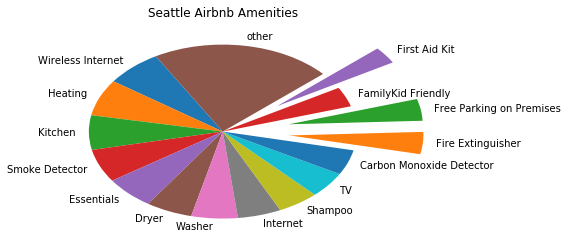

In [435]:
plt.pie(refined_seattle_amenities_stat.values,labels=refined_seattle_amenities_stat.index,startangle=120,explode=(0,0,0,0,0,0,0,0,0,0,0,0.5,0.5,0,0.5,0));
plt.title("Seattle Airbnb Amenities")

Text(0.5,1,'Boston Airbnb Amenities')

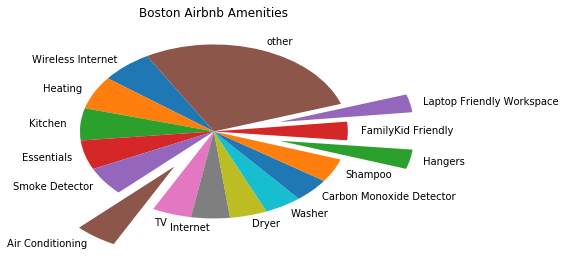

In [436]:
plt.pie(refined_boston_amenities_stat.values,labels=refined_boston_amenities_stat.index,startangle=120,explode=(0,0,0,0,0,0.5,0,0,0,0,0,0,0.5,0,0.5,0));
plt.title("Boston Airbnb Amenities")

# Section 3 Predict price based on objective features of hosts

## Data Preparation

In [240]:
seattle_listings=pd.read_csv("seattle/listings.csv")
boston_listings=pd.read_csv("boston/listings.csv")

I would like to pick up some siginificant feature of interest. This includes neighbourhood, property type, room_type, number of bathrooms, bedrooms, beds, bed_type,amenities,cancellation policy and price

In seattle data, the neighbouhood_group_cleansed has already put the neighbour hood into several groups. However, there is no value in boston data. Therefore, I will use neighbourhood_cleansed for boston data set.

In [241]:
seattle_feature_of_interest=["neighbourhood_group_cleansed","property_type","room_type","bathrooms","bedrooms","beds","bed_type","amenities","cancellation_policy","price"]

In [242]:
boston_feature_of_interest=["neighbourhood_cleansed","property_type","room_type","bathrooms","bedrooms","beds","bed_type","amenities","cancellation_policy","price"]

In [243]:
seattle_feature=seattle_listings[seattle_feature_of_interest]

In [244]:
seattle_feature.head()

neighbourhood_group_cleansed property_type        room_type  bathrooms  \
0                   Queen Anne     Apartment  Entire home/apt        1.0   
1                   Queen Anne     Apartment  Entire home/apt        1.0   
2                   Queen Anne         House  Entire home/apt        4.5   
3                   Queen Anne     Apartment  Entire home/apt        1.0   
4                   Queen Anne         House  Entire home/apt        2.0   

   bedrooms  beds  bed_type  \
0       1.0   1.0  Real Bed   
1       1.0   1.0  Real Bed   
2       5.0   7.0  Real Bed   
3       0.0   2.0  Real Bed   
4       3.0   3.0  Real Bed   

                                           amenities cancellation_policy  \
0  {TV,"Cable TV",Internet,"Wireless Internet","A...            moderate   
1  {TV,Internet,"Wireless Internet",Kitchen,"Free...              strict   
2  {TV,"Cable TV",Internet,"Wireless Internet","A...              strict   
3  {Internet,"Wireless Internet",Kitchen,"Indoor ...            flexible   
4  {TV,"Cable TV",Internet,"Wireless Internet",Ki...              strict   

     price  
0   $85.00  
1  $150.00  
2  $975.00  
3  $100.00  
4  $450.00

In [245]:
boston_feature=boston_listings[boston_feature_of_interest]
boston_feature.head()

neighbourhood_cleansed property_type        room_type  bathrooms  bedrooms  \
0             Roslindale         House  Entire home/apt        1.5       2.0   
1             Roslindale     Apartment     Private room        1.0       1.0   
2             Roslindale     Apartment     Private room        1.0       1.0   
3             Roslindale         House     Private room        1.0       1.0   
4             Roslindale         House     Private room        1.5       1.0   

   beds  bed_type                                          amenities  \
0   3.0  Real Bed  {TV,"Wireless Internet",Kitchen,"Free Parking ...   
1   1.0  Real Bed  {TV,Internet,"Wireless Internet","Air Conditio...   
2   1.0  Real Bed  {TV,"Cable TV","Wireless Internet","Air Condit...   
3   2.0  Real Bed  {TV,Internet,"Wireless Internet","Air Conditio...   
4   2.0  Real Bed  {Internet,"Wireless Internet","Air Conditionin...   

  cancellation_policy    price  
0            moderate  $250.00  
1            moderate   $65.00  
2            moderate   $65.00  
3            moderate   $75.00  
4            flexible   $79.00

### Clean Data

In [246]:
seattle_feature[seattle_feature.isnull().mean(axis=1)>0]

neighbourhood_group_cleansed property_type        room_type  bathrooms  \
1242                     Downtown     Apartment  Entire home/apt        NaN   
1314                     Downtown     Apartment  Entire home/apt        NaN   
1357                     Downtown     Apartment  Entire home/apt        NaN   
1378                     Downtown     Apartment  Entire home/apt        NaN   
1429                     Downtown     Apartment  Entire home/apt        1.0   
1492                     Downtown     Apartment  Entire home/apt        1.0   
1493                     Downtown         Other  Entire home/apt        1.0   
1853                 West Seattle     Apartment  Entire home/apt        1.0   
1961          Other neighborhoods         House     Private room        NaN   
1975          Other neighborhoods        Chalet     Private room        NaN   
2048          Other neighborhoods         House  Entire home/apt        NaN   
2096                  Beacon Hill         House     Private room        NaN   
2184               Rainier Valley           NaN  Entire home/apt        1.0   
2306               Rainier Valley         House  Entire home/apt        NaN   
2408                    Northgate         House     Private room        NaN   
2432                    Northgate         House     Private room        NaN   
2437                    Northgate         House     Private room        NaN   
2619                 Capitol Hill         House  Entire home/apt        1.0   
2698                 Capitol Hill     Apartment  Entire home/apt        NaN   
2717                 Capitol Hill         House     Private room        NaN   
2915                 Capitol Hill     Apartment  Entire home/apt        1.0   
2953                 Capitol Hill     Apartment  Entire home/apt        NaN   
3337                    Northgate         House  Entire home/apt        NaN   

      bedrooms  beds       bed_type  \
1242       1.0   2.0       Real Bed   
1314       1.0   2.0       Real Bed   
1357       2.0   3.0       Real Bed   
1378       1.0   1.0       Real Bed   
1429       NaN   1.0       Real Bed   
1492       NaN   1.0       Real Bed   
1493       NaN   2.0       Real Bed   
1853       NaN   1.0       Real Bed   
1961       1.0   NaN       Real Bed   
1975       1.0   1.0       Real Bed   
2048       2.0   4.0       Real Bed   
2096       1.0   1.0       Real Bed   
2184       2.0   2.0       Real Bed   
2306       1.0   2.0       Real Bed   
2408       1.0   1.0       Real Bed   
2432       1.0   1.0       Real Bed   
2437       1.0   2.0       Real Bed   
2619       NaN   1.0       Real Bed   
2698       1.0   1.0       Real Bed   
2717       1.0   1.0       Real Bed   
2915       NaN   1.0  Pull-out Sofa   
2953       1.0   1.0       Real Bed   
3337       2.0   1.0       Real Bed   

                                              amenities cancellation_policy  \
1242  {TV,"Cable TV",Internet,"Wireless Internet","W...              strict   
1314  {TV,"Cable TV",Internet,"Wireless Internet","W...              strict   
1357  {TV,"Cable TV",Internet,"Wireless Internet","W...              strict   
1378  {TV,"Cable TV",Internet,"Wireless Internet","A...              strict   
1429  {TV,Internet,"Wireless Internet","Wheelchair A...              strict   
1492                                                 {}              strict   
1493  {"Cable TV",Internet,"Wireless Internet",Pool,...              strict   
1853  {TV,"Cable TV",Internet,"Wireless Internet",Ki...              strict   
1961                                                 {}            flexible   
1975  {TV,"Free Parking on Premises","Pets live on t...            flexible   
2048  {"Wireless Internet","Smoke Detector","Carbon ...              strict   
2096  {TV,"Cable TV","Wireless Internet","Free Parki...            moderate   
2184  {"Wireless Internet",Kitchen,"Free Parking on ...              strict   
2306  {"Cable TV","Wireless Internet",Kitchen,"Free ...          

In [247]:
boston_feature[boston_feature.isnull().mean(axis=1)>0]

neighbourhood_cleansed    property_type        room_type  bathrooms  \
103           Jamaica Plain            House     Private room        NaN   
494            Mission Hill        Apartment     Private room        1.0   
630               North End        Apartment      Shared room        NaN   
755               North End        Apartment  Entire home/apt        NaN   
800                 Roxbury        Apartment  Entire home/apt        NaN   
820                 Roxbury  Bed & Breakfast     Private room        NaN   
825                 Roxbury            House     Private room        NaN   
888                 Roxbury        Apartment  Entire home/apt        NaN   
910                 Roxbury        Apartment     Private room        NaN   
918               South End        Apartment  Entire home/apt        1.0   
920               South End        Apartment  Entire home/apt        1.0   
924               South End        Apartment  Entire home/apt        1.0   
989               South End            House     Private room        NaN   
1095              South End        Apartment  Entire home/apt        1.0   
1117              South End        Apartment  Entire home/apt        1.0   
1120              South End  Bed & Breakfast     Private room        NaN   
1132              South End        Apartment  Entire home/apt        1.0   
1251               Back Bay        Apartment  Entire home/apt        1.0   
1321               Back Bay              NaN  Entire home/apt        1.0   
1366               Back Bay        Apartment  Entire home/apt        1.0   
1419               Back Bay        Apartment  Entire home/apt        1.0   
1959            Beacon Hill        Apartment  Entire home/apt        1.0   
2061               Downtown              NaN  Entire home/apt        1.0   
2196                 Fenway        Apartment     Private room        NaN   
2201                 Fenway        Apartment  Entire home/apt        NaN   
2203                 Fenway        Apartment     Private room        1.0   
2785             Dorchester            House     Private room        NaN   
2819             Dorchester            House     Private room        NaN   
2865             Dorchester            House     Private room        1.0   
3393                Allston              NaN     Private room        1.0   
3557  Longwood Medical Area        Apartment     Private room        1.0   

      bedrooms  beds  bed_type  \
103        1.0   1.0  Real Bed   
494        1.0   NaN  Real Bed   
630        1.0   1.0  Real Bed   
755        1.0   NaN  Real Bed   
800        1.0   1.0  Real Bed   
820        1.0   NaN  Real Bed   
825        1.0   NaN  Real Bed   
888        1.0   1.0  Real Bed   
910        1.0   NaN  Real Bed   
918        NaN   1.0  Real Bed   
920        NaN   1.0  Real Bed   
924        NaN   1.0  Real Bed   
989        1.0   1.0  Real Bed   
1095       NaN   1.0  Real Bed   
1117       NaN   1.0  Real Bed   
1120       1.0   1.0  Real Bed   
1132       NaN   1.0  Real Bed   
1251       NaN   1.0  Real Bed   
1321       0.0   1.0  Real Bed   
1366       NaN   1.0  Real Bed   
1419       NaN   1.0  Real Bed   
1959       NaN   1.0  Real Bed   
2061       1.0   1.0  Real Bed   
2196       1.0   1.0  Real Bed   
2201       2.0   2.0  Real Bed   
2203       1.0   NaN  Real Bed   
2785       1.0   1.0  Real Bed   
2819       1.0   NaN  Real Bed   
2865       1.0   NaN  Real Bed   
3393       1.0   1.0  Real Bed   
3557       1.0   NaN  Real Bed   

                                              amenities cancellation_policy  \
103   {Internet,"Wireless Internet","Air Conditionin...            moderate   
494   {"Wireless Internet","Air Conditioning",Kitche...            moderate   
630                                                  {}            flexible   
755   {TV,"Cable TV",Internet,"Wireless Internet","A...              strict   
800   {TV,"Cable TV",Internet,"Wireless Internet","A...              strict   
820   {"A

Besides amenities, there are missing values in property_type, bathrooms, bedrooms and beds. For property_type, I will assign the most common property_type to the missing values. For bathrooms, bedrooms and beds, it is reasonable to use 1 to replace the missing value.

In [248]:
def clean_feature(df):
    df["bathrooms"].fillna(1,inplace=True)
    df["bedrooms"].fillna(1,inplace=True)
    df["beds"].fillna(1,inplace=True)
    df["property_type"].fillna(df["property_type"].value_counts().index[0],inplace=True)
    return df
    

In [249]:
seattle_feature_clean=clean_feature(seattle_feature)
boston_feature_clean=clean_feature(boston_feature)

E:\Users\xbxb\Anaconda3\lib\site-packages\pandas\core\generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [250]:
seattle_feature[seattle_feature.isnull().mean(axis=1)>0]

Empty DataFrame
Columns: [neighbourhood_group_cleansed, property_type, room_type, bathrooms, bedrooms, beds, bed_type, amenities, cancellation_policy, price]
Index: []

In [251]:
boston_feature[boston_feature.isnull().mean(axis=1)>0]

Empty DataFrame
Columns: [neighbourhood_cleansed, property_type, room_type, bathrooms, bedrooms, beds, bed_type, amenities, cancellation_policy, price]
Index: []

after double checking, there is not missing value in the dataset.

## Feature engineering

First, check the categorical data set

In [252]:
seattle_feature['neighbourhood_group_cleansed'].value_counts()

Other neighborhoods    794
Capitol Hill           567
Downtown               530
Central Area           369
Queen Anne             295
Ballard                230
West Seattle           203
Rainier Valley         159
University District    122
Beacon Hill            118
Cascade                 89
Northgate               80
Delridge                79
Lake City               67
Magnolia                61
Seward Park             44
Interbay                11
Name: neighbourhood_group_cleansed, dtype: int64

In [253]:
boston_feature['neighbourhood_cleansed'].value_counts()

Jamaica Plain              343
South End                  326
Back Bay                   302
Fenway                     290
Dorchester                 269
Allston                    260
Beacon Hill                194
Brighton                   185
South Boston               174
Downtown                   172
East Boston                150
Roxbury                    144
North End                  143
Mission Hill               124
Charlestown                111
South Boston Waterfront     83
Chinatown                   71
Roslindale                  56
West End                    49
West Roxbury                46
Hyde Park                   31
Mattapan                    24
Bay Village                 24
Longwood Medical Area        9
Leather District             5
Name: neighbourhood_cleansed, dtype: int64

for boston area, I will put Longwood Medical Area and leather distric area into "other" category

In [254]:
seattle_feature["property_type"].value_counts()

House              1734
Apartment          1708
Townhouse           118
Condominium          91
Loft                 40
Bed & Breakfast      37
Other                22
Cabin                21
Camper/RV            13
Bungalow             13
Boat                  8
Tent                  5
Treehouse             3
Chalet                2
Dorm                  2
Yurt                  1
Name: property_type, dtype: int64

I will put boat,tent,treehouse, chalet,dorm and yurt into same category "other"

In [255]:
boston_feature["property_type"].value_counts()

Apartment          2615
House               562
Condominium         231
Townhouse            54
Bed & Breakfast      41
Loft                 39
Other                17
Boat                 12
Villa                 6
Entire Floor          4
Dorm                  2
Camper/RV             1
Guesthouse            1
Name: property_type, dtype: int64

i will put villa, entire floor, dorm camper/RV guesthouse into the same category "other"

In [256]:
seattle_feature["room_type"].value_counts()

Entire home/apt    2541
Private room       1160
Shared room         117
Name: room_type, dtype: int64

In [257]:
boston_feature["room_type"].value_counts()

Entire home/apt    2127
Private room       1378
Shared room          80
Name: room_type, dtype: int64

In [258]:
seattle_feature["bed_type"].value_counts()

Real Bed         3657
Futon              74
Pull-out Sofa      47
Airbed             27
Couch              13
Name: bed_type, dtype: int64

In [259]:
boston_feature["bed_type"].value_counts()

Real Bed         3453
Futon              51
Airbed             40
Pull-out Sofa      31
Couch              10
Name: bed_type, dtype: int64

In [260]:
seattle_feature["cancellation_policy"].value_counts()

strict      1417
moderate    1251
flexible    1150
Name: cancellation_policy, dtype: int64

In [261]:
boston_feature["cancellation_policy"].value_counts()

strict             1582
flexible            999
moderate            919
super_strict_30      85
Name: cancellation_policy, dtype: int64

for numerical data, I will use feature/bed instead of number of features. If host A and host B both has 2 bathroom and 2 bedroom available and host B put 2 beds in each bedroom instead of 1, host B probably can collect more money than host A.

In [262]:
def seattle_engineering_feature(df_feature):
    for i in range(0,df_feature.shape[0]):
        print (i, end="\r")
        if df_feature["beds"].iloc[i]==0:
            df_feature["beds"].iloc[i]=1
        df_feature["price"].iloc[i]=float(df_feature["price"].iloc[i].replace(",","").replace("$",""))/df_feature["beds"].iloc[i]
        df_feature["bathrooms"].iloc[i]=df_feature["bathrooms"].iloc[i]/df_feature["beds"].iloc[i]
        df_feature["bedrooms"].iloc[i]=df_feature["bedrooms"].iloc[i]/df_feature["beds"].iloc[i]
        if df_feature["property_type"].iloc[i] in ["Boat","Tent","Treehouse","Chalet","Dorm","Yurt"]:
            df_feature["property_type"].iloc[i]="Other"
    return df_feature
    

In [263]:
seattle_feature_e=seattle_engineering_feature(seattle_feature)

E:\Users\xbxb\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
E:\Users\xbxb\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
E:\Users\xbxb\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
E:\Users\xbxb\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 


E:\Users\xbxb\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [264]:
seattle_feature_e.to_csv('seattle_feature_e.csv', sep=';', index = False)

In [265]:
def boston_engineering_feature(df_feature):
    
    for i in range(0,df_feature.shape[0]):
        print (i, end="\r")
        if df_feature["beds"].iloc[i]==0:
            df_feature["beds"].iloc[i]=1
        df_feature["price"].iloc[i]=float(df_feature["price"].iloc[i].replace(",","").replace("$",""))/df_feature["beds"].iloc[i]
        df_feature["bathrooms"].iloc[i]=df_feature["bathrooms"].iloc[i]/df_feature["beds"].iloc[i]
        df_feature["bedrooms"].iloc[i]=df_feature["bedrooms"].iloc[i]/df_feature["beds"].iloc[i]
        if df_feature["property_type"].iloc[i] in ["Villa","Entire floor","Dorm","Camper/RV","Guesthouse"]:
            df_feature["property_type"].iloc[i]="Other"
        if df_feature["neighbourhood_cleansed"].iloc[i] in ["Longwood Medical Area","Leather Distric"]:
            df_feature["neighbourhood_cleansed"].iloc[i]="Other"
    return df_feature

In [266]:
boston_feature_e=boston_engineering_feature(boston_feature)

E:\Users\xbxb\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
E:\Users\xbxb\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
E:\Users\xbxb\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
E:\Users\xbxb\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 


E:\Users\xbxb\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


E:\Users\xbxb\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


E:\Users\xbxb\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [267]:
boston_feature_e.to_csv('boston_feature_e.csv', sep=';', index = False)

In [278]:
seattle_feature_e.rename(index=str, columns={"price":"price/bed","bathrooms":"bathrooms/bed","bedrooms":"bedrooms/bed","neighbourhood_group_cleansed":"neighbourhood"},inplace=True);

In [279]:
boston_feature_e.rename(index=str, columns={"price":"price/bed","bathrooms":"bathrooms/bed","bedrooms":"bedrooms/bed","neighbourhood_cleansed":"neighbourhood"},inplace=True);

Engineering the amenities feature

In [270]:
seattle_feature_e=amenities_process(seattle_feature_e,"amenities")
boston_feature_e=amenities_process(boston_feature_e,"amenities")

In [280]:
boston_feature_e.head()

neighbourhood property_type        room_type  bathrooms/bed  bedrooms/bed  \
0    Roslindale         House  Entire home/apt           0.50      0.666667   
1    Roslindale     Apartment     Private room           1.00      1.000000   
2    Roslindale     Apartment     Private room           1.00      1.000000   
3    Roslindale         House     Private room           0.50      0.500000   
4    Roslindale         House     Private room           0.75      0.500000   

   beds  bed_type                                          amenities  \
0   3.0  Real Bed  [TV, Wireless Internet, Kitchen, Free Parking ...   
1   1.0  Real Bed  [TV, Internet, Wireless Internet, Air Conditio...   
2   1.0  Real Bed  [TV, Cable TV, Wireless Internet, Air Conditio...   
3   2.0  Real Bed  [TV, Internet, Wireless Internet, Air Conditio...   
4   2.0  Real Bed  [Internet, Wireless Internet, Air Conditioning...   

  cancellation_policy price/bed  
0            moderate   83.3333  
1            moderate        65  
2            moderate        65  
3            moderate      37.5  
4            flexible      39.5

In [271]:
def engineering_amenities_df(df):
    for i in df.index:
        for j in range(0,len(df["amenities"][i])):
            if df["amenities"][i][j] not in df.columns:
                       df[df["amenities"][i][j]]=np.nan
                       df[df["amenities"][i][j]][i]=1
            else:
                       df[df["amenities"][i][j]][i]=1
    
    
    
    return df

In [281]:
seattle_feature_e=engineering_amenities_df(seattle_feature_e)

E:\Users\xbxb\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
E:\Users\xbxb\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [282]:
boston_feature_e=engineering_amenities_df(boston_feature_e)

E:\Users\xbxb\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
E:\Users\xbxb\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [287]:
seattle_feature_e.to_csv('seattle_feature_e1.csv', sep=';', index = False)
boston_feature_e.to_csv('boston_feature_e1.csv', sep=';', index = False)

In [338]:
seattle_feature_e=pd.read_csv("seattle_feature_e1.csv", sep=';')
boston_feature_e=pd.read_csv("boston_feature_e1.csv", sep=';')

In [339]:
seattle_feature_e.fillna(0,inplace=True)

In [340]:
boston_feature_e.fillna(0,inplace=True)

In [341]:
seattle_feature_e.drop(columns=["beds","amenities"],inplace=True)

In [342]:
boston_feature_e.drop(columns=["beds","amenities"],inplace=True)

encode the categorical data

In [357]:
from sklearn.preprocessing import OneHotEncoder

def encode_multilevel_cat(df,colname):
    colencoder=OneHotEncoder()
    tempcol=colencoder.fit_transform(df[colname].values.reshape(-1,1)).toarray()
    dftempcol=pd.DataFrame(tempcol,columns=[colname+"_"+j for j in colencoder.categories_[0]])
    newdf=df.drop([colname],axis=1)
    newdf=pd.concat([newdf,dftempcol],axis=1)
    return newdf

In [358]:
for i in cat_col:
    seattle_feature_e=encode_multilevel_cat(seattle_feature_e,i)
    boston_feature_e=encode_multilevel_cat(boston_feature_e,i)
    print(i,'has been encoded')

neighbourhood has been encoded
property_type has been encoded
room_type has been encoded
bed_type has been encoded
cancellation_policy has been encoded


### Modeling Price/bed

#### Split X andy


In [362]:
X_s=seattle_feature_e.drop(columns=["price/bed"])

In [392]:
X_s.head()

bathrooms/bed  bedrooms/bed   TV  Cable TV  Internet  Wireless Internet  \
0       1.000000      1.000000  1.0       1.0       1.0                1.0   
1       1.000000      1.000000  1.0       0.0       1.0                1.0   
2       0.642857      0.714286  1.0       1.0       1.0                1.0   
3       0.500000      0.000000  0.0       0.0       1.0                1.0   
4       0.666667      1.000000  1.0       1.0       1.0                1.0   

   Air Conditioning  Kitchen  Heating  FamilyKid Friendly  \
0               1.0      1.0      1.0                 1.0   
1               0.0      1.0      1.0                 1.0   
2               1.0      1.0      1.0                 1.0   
3               0.0      1.0      1.0                 1.0   
4               0.0      1.0      1.0                 1.0   

              ...              room_type_Private room  room_type_Shared room  \
0             ...                                 0.0                    0.0   
1             ...                                 0.0                    0.0   
2             ...                                 0.0                    0.0   
3             ...                                 0.0                    0.0   
4             ...                                 0.0                    0.0   

   bed_type_Airbed  bed_type_Couch  bed_type_Futon  bed_type_Pull-out Sofa  \
0              0.0             0.0             0.0                     0.0   
1              0.0             0.0             0.0                     0.0   
2              0.0             0.0             0.0                     0.0   
3              0.0             0.0             0.0                     0.0   
4              0.0             0.0             0.0                     0.0   

   bed_type_Real Bed  cancellation_policy_flexible  \
0                1.0                           0.0   
1                1.0                           0.0   
2                1.0                           0.0   
3                1.0                           1.0   
4                1.0                           0.0   

   cancellation_policy_moderate  cancellation_policy_strict  
0                           1.0                         0.0  
1                           0.0                         1.0  
2                           0.0                         1.0  
3                           0.0                         0.0  
4                           0.0                         1.0  

[5 rows x 82 columns]

In [363]:
y_s=seattle_feature_e["price/bed"]

#### find the most important feature

after engineering feature, we have lots of feature in the dataset. However, I want to build the model based on the important features. Therefore, I will select the features first.

In [404]:
from sklearn.feature_selection import f_regression

In [405]:
from sklearn.feature_selection import SelectKBest

In [453]:
feat_selector = SelectKBest(f_regression, k=40)
_ = feat_selector.fit(X_s, y_s)

In [454]:
feat_scores = pd.DataFrame()
feat_scores["F Score"] = feat_selector.scores_
feat_scores["P Value"] = feat_selector.pvalues_
feat_scores["Support"] = feat_selector.get_support()
feat_scores["Attribute"] = X_s.columns

In [455]:
feature_of_importance_s=feat_scores[feat_scores["Support"]==True]["Attribute"].unique()

#### Split traning set, testing set and fit the model

In [456]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

In [457]:
X_train_s,X_test_s, y_train_s, y_test_s = train_test_split(X_s[feature_of_importance_s],y_s,test_size=0.30, random_state=101)

In [458]:
lm_model_s = LinearRegression(normalize=True)
lm_model_s.fit(X_train_s,y_train_s)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [459]:
y_test_preds_s = lm_model_s.predict(X_test_s)

y_train_preds_s = lm_model_s.predict(X_train_s)

In [460]:
r2_score(y_test_s, y_test_preds_s)

0.2837739123634828

In [461]:
r2_score(y_train_s, y_train_preds_s)

0.3181456190904771

In [462]:
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test_s, y_test_preds_s));

print('MSE:', metrics.mean_squared_error(y_test_s, y_test_preds_s));

print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test_s, y_test_preds_s)));

MAE: 25.456917175683536
MSE: 1412.932744066772
RMSE: 37.58899764647592


It seems that the r2_score is low. This model may not accuratly predict the price. However, our purpose is to find out the most important features that affect the price. Therefore, I will exam the coefficients of each feature and pick up the top 10 and bottom 10 coefficient values.

In [463]:
coefs_df_s = pd.DataFrame()

coefs_df_s['est_int'] = X_train_s.columns

coefs_df_s['coefs'] = lm_model_s.coef_

coefs_df_s['abs_coefs'] = np.abs(lm_model_s.coef_)

In [471]:
plot_coefs=coefs_df_s.sort_values(by=["coefs"],ascending=True)

In [474]:
plot_coefs.head()

est_int      coefs  abs_coefs
24             neighbourhood_Delridge -18.507806  18.507806
30       neighbourhood_Rainier Valley -16.349942  16.349942
27            neighbourhood_Northgate -14.863323  14.863323
32  neighbourhood_University District -14.482880  14.482880
21          neighbourhood_Beacon Hill -13.908871  13.908871

In [476]:
top10_s=plot_coefs.iloc[3:12]

In [477]:
bottom10_s=plot_coefs.iloc[-10:]

In [479]:
plot_20_s=pd.concat([top10_s,bottom10_s],axis=0,ignore_index=True)

In [484]:
plot_20_s["est_int"].values

array(['neighbourhood_University District', 'neighbourhood_Beacon Hill',
       'neighbourhood_Seward Park', 'Hangers', 'neighbourhood_Ballard',
       'property_type_Condominium', 'property_type_House',
       'Smoke Detector', 'neighbourhood_Lake City',
       'BuzzerWireless Intercom', 'Lock on Bedroom Door',
       'neighbourhood_Capitol Hill', 'neighbourhood_Queen Anne',
       'neighbourhood_Cascade', 'neighbourhood_Downtown',
       'Elevator in Building', 'Doorman', 'bedrooms/bed', 'bathrooms/bed'],
      dtype=object)

Text(0.5,1,'Seattle-Coefficient of Importance Features')

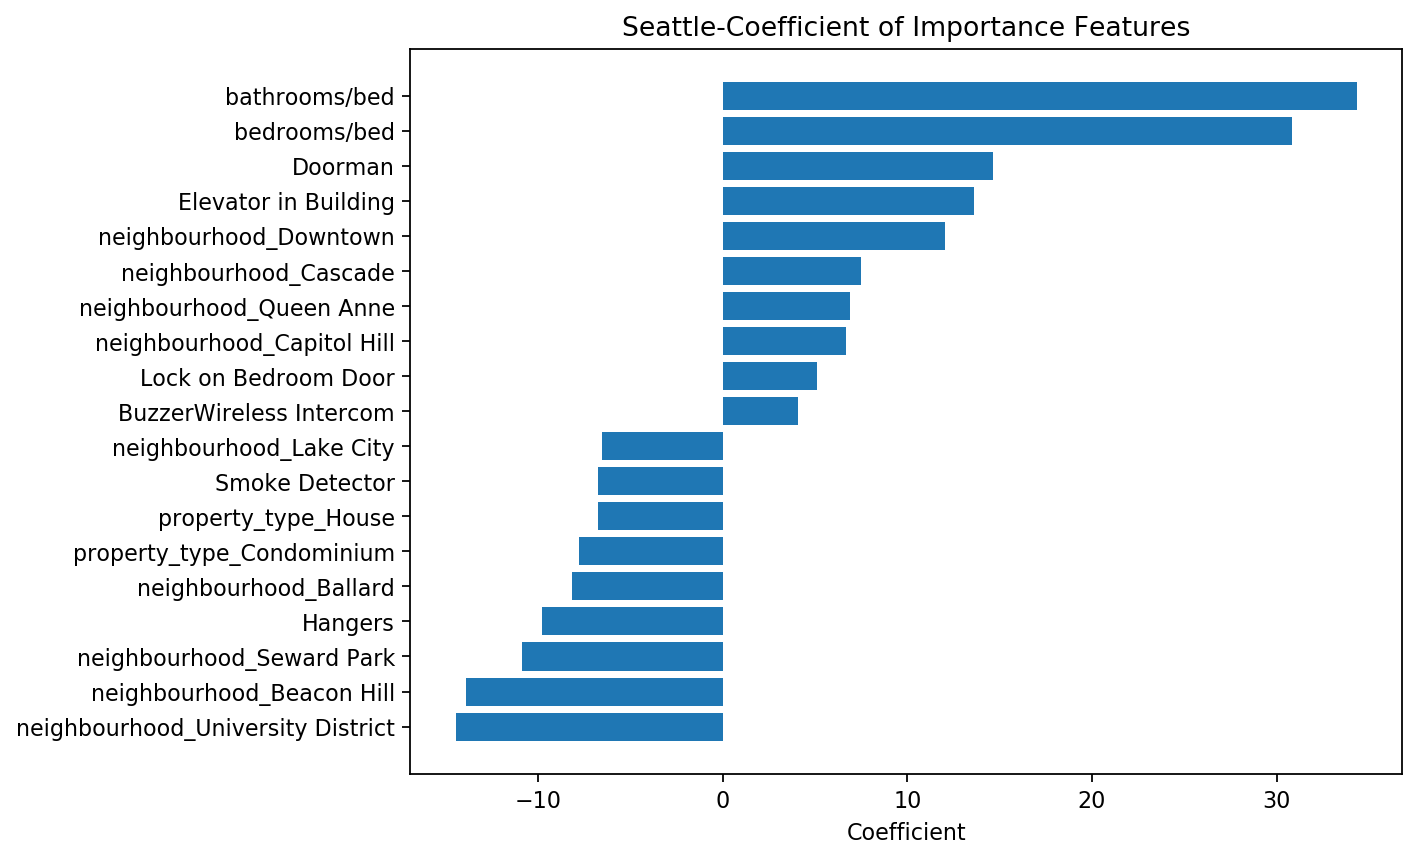

In [492]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=160, facecolor='w', edgecolor='k')
y_pos = np.arange(len(plot_20_s["est_int"].values))
plt.barh(plot_20_s["est_int"],plot_20_s["coefs"]);
plt.yticks(y_pos, plot_20_s["est_int"].values);
plt.xlabel("Coefficient")
plt.title("Seattle-Coefficient of Importance Features")

In [493]:
X_b=boston_feature_e.drop(columns=["price/bed"])
y_b=boston_feature_e["price/bed"]
feat_selector_b = SelectKBest(f_regression, k=40)
_ = feat_selector_b.fit(X_b, y_b)
feat_scores = pd.DataFrame()
feat_scores["F Score"] = feat_selector_b.scores_
feat_scores["P Value"] = feat_selector_b.pvalues_
feat_scores["Support"] = feat_selector_b.get_support()
feat_scores["Attribute"] = X_b.columns
feature_of_importance_b=feat_scores[feat_scores["Support"]==True]["Attribute"].unique()
X_train_b,X_test_b, y_train_b, y_test_b = train_test_split(X_b[feature_of_importance_b],y_b,test_size=0.30, random_state=101)
lm_model_b = LinearRegression(normalize=True)
lm_model_b.fit(X_train_b,y_train_b)
y_test_preds_b = lm_model_b.predict(X_test_b)
y_train_preds_b = lm_model_b.predict(X_train_b)
r2_score(y_test_b, y_test_preds_b)

0.19781643612240463

In [494]:
r2_score(y_train_b, y_train_preds_b)

0.2911744160967671

In [495]:
coefs_df_b = pd.DataFrame()

coefs_df_b['est_int'] = X_train_b.columns

coefs_df_b['coefs'] = lm_model_b.coef_

coefs_df_b['abs_coefs'] = np.abs(lm_model_b.coef_)

In [496]:
plot_coefb=coefs_df_b.sort_values(by=["coefs"],ascending=True)

In [506]:
top10_b=plot_coefb.iloc[0:10]
bottom10_b=plot_coefb.iloc[-10:]
plot_20_b=pd.concat([top10_b,bottom10_b],axis=0,ignore_index=True)

In [507]:
bottom10_b

est_int      coefs  abs_coefs
0                           bathrooms/bed  30.497331  30.497331
27                   neighbourhood_Fenway  30.579754  30.579754
32                neighbourhood_South End  37.631960  37.631960
1                            bedrooms/bed  38.957171  38.957171
25                 neighbourhood_Downtown  41.779768  41.779768
21                 neighbourhood_Back Bay  43.354660  43.354660
36              room_type_Entire home/apt  48.317306  48.317306
22              neighbourhood_Beacon Hill  52.261461  52.261461
39    cancellation_policy_super_strict_30  60.716002  60.716002
31  neighbourhood_South Boston Waterfront  69.049283  69.049283

In [508]:
plot_20_b

est_int      coefs  abs_coefs
0                  neighbourhood_Mattapan -30.049402  30.049402
1                neighbourhood_Roslindale -25.567582  25.567582
2                neighbourhood_Dorchester -24.994926  24.994926
3              neighbourhood_West Roxbury -23.339346  23.339346
4               neighbourhood_East Boston -21.526680  21.526680
5                   neighbourhood_Allston -19.355839  19.355839
6                  neighbourhood_Brighton -17.229790  17.229790
7                                     Gym -13.074384  13.074384
8             neighbourhood_Jamaica Plain -13.049378  13.049378
9                     property_type_House -11.185846  11.185846
10                          bathrooms/bed  30.497331  30.497331
11                   neighbourhood_Fenway  30.579754  30.579754
12                neighbourhood_South End  37.631960  37.631960
13                           bedrooms/bed  38.957171  38.957171
14                 neighbourhood_Downtown  41.779768  41.779768
15                 neighbourhood_Back Bay  43.354660  43.354660
16              room_type_Entire home/apt  48.317306  48.317306
17              neighbourhood_Beacon Hill  52.261461  52.261461
18    cancellation_policy_super_strict_30  60.716002  60.716002
19  neighbourhood_South Boston Waterfront  69.049283  69.049283

Text(0.5,1,'Boston-Coefficient of Importance Features')

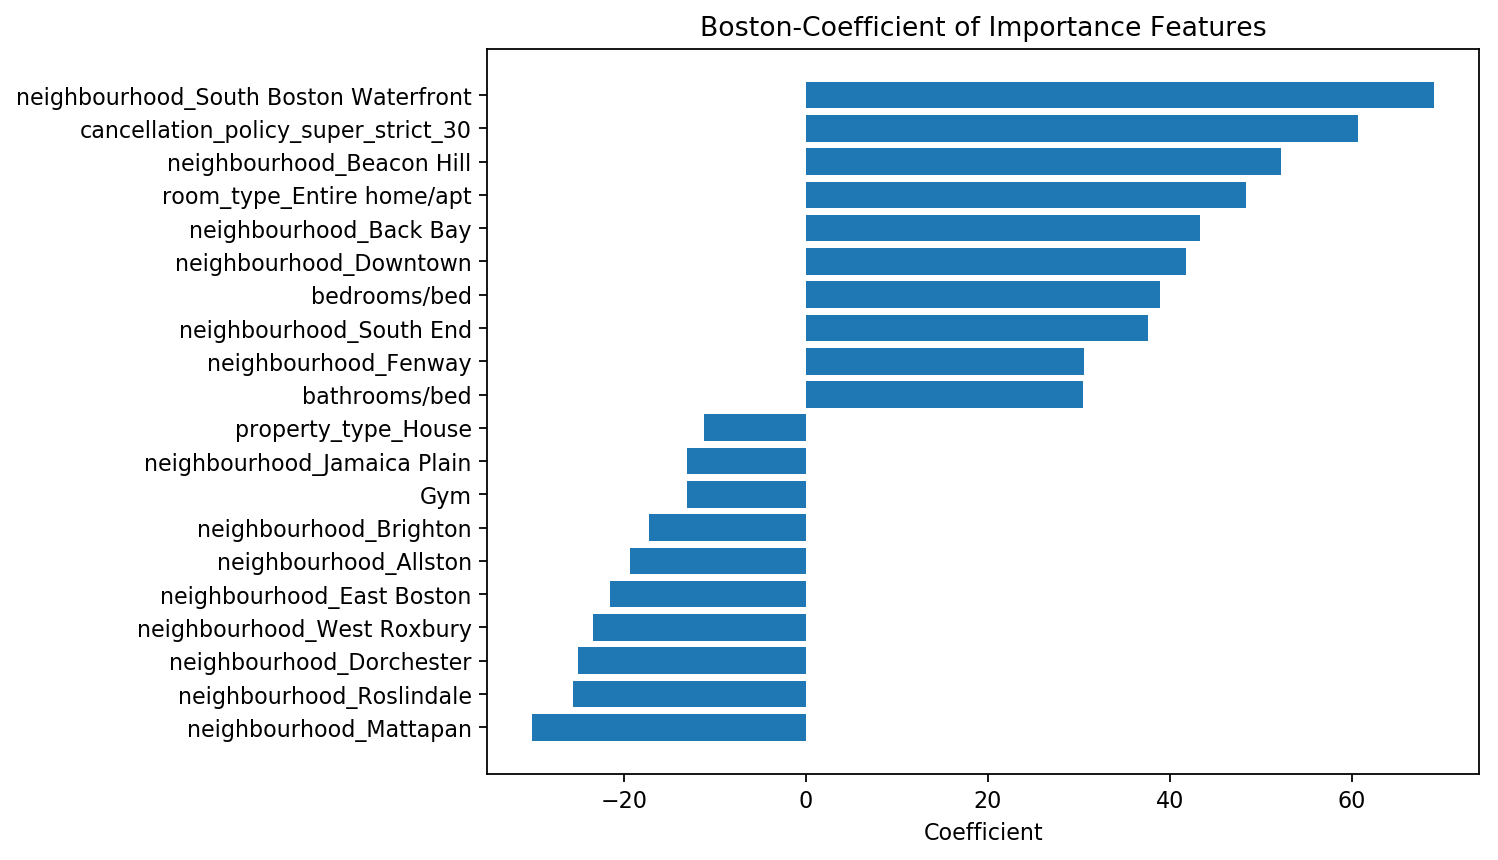

In [509]:

figure(num=None, figsize=(8, 6), dpi=160, facecolor='w', edgecolor='k')
y_pos = np.arange(len(plot_20_b["est_int"].values))
plt.barh(plot_20_b["est_int"],plot_20_b["coefs"]);
plt.yticks(y_pos, plot_20_b["est_int"].values);
plt.xlabel("Coefficient")
plt.title("Boston-Coefficient of Importance Features")